In [3]:
import torch
import random
import numpy as np

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

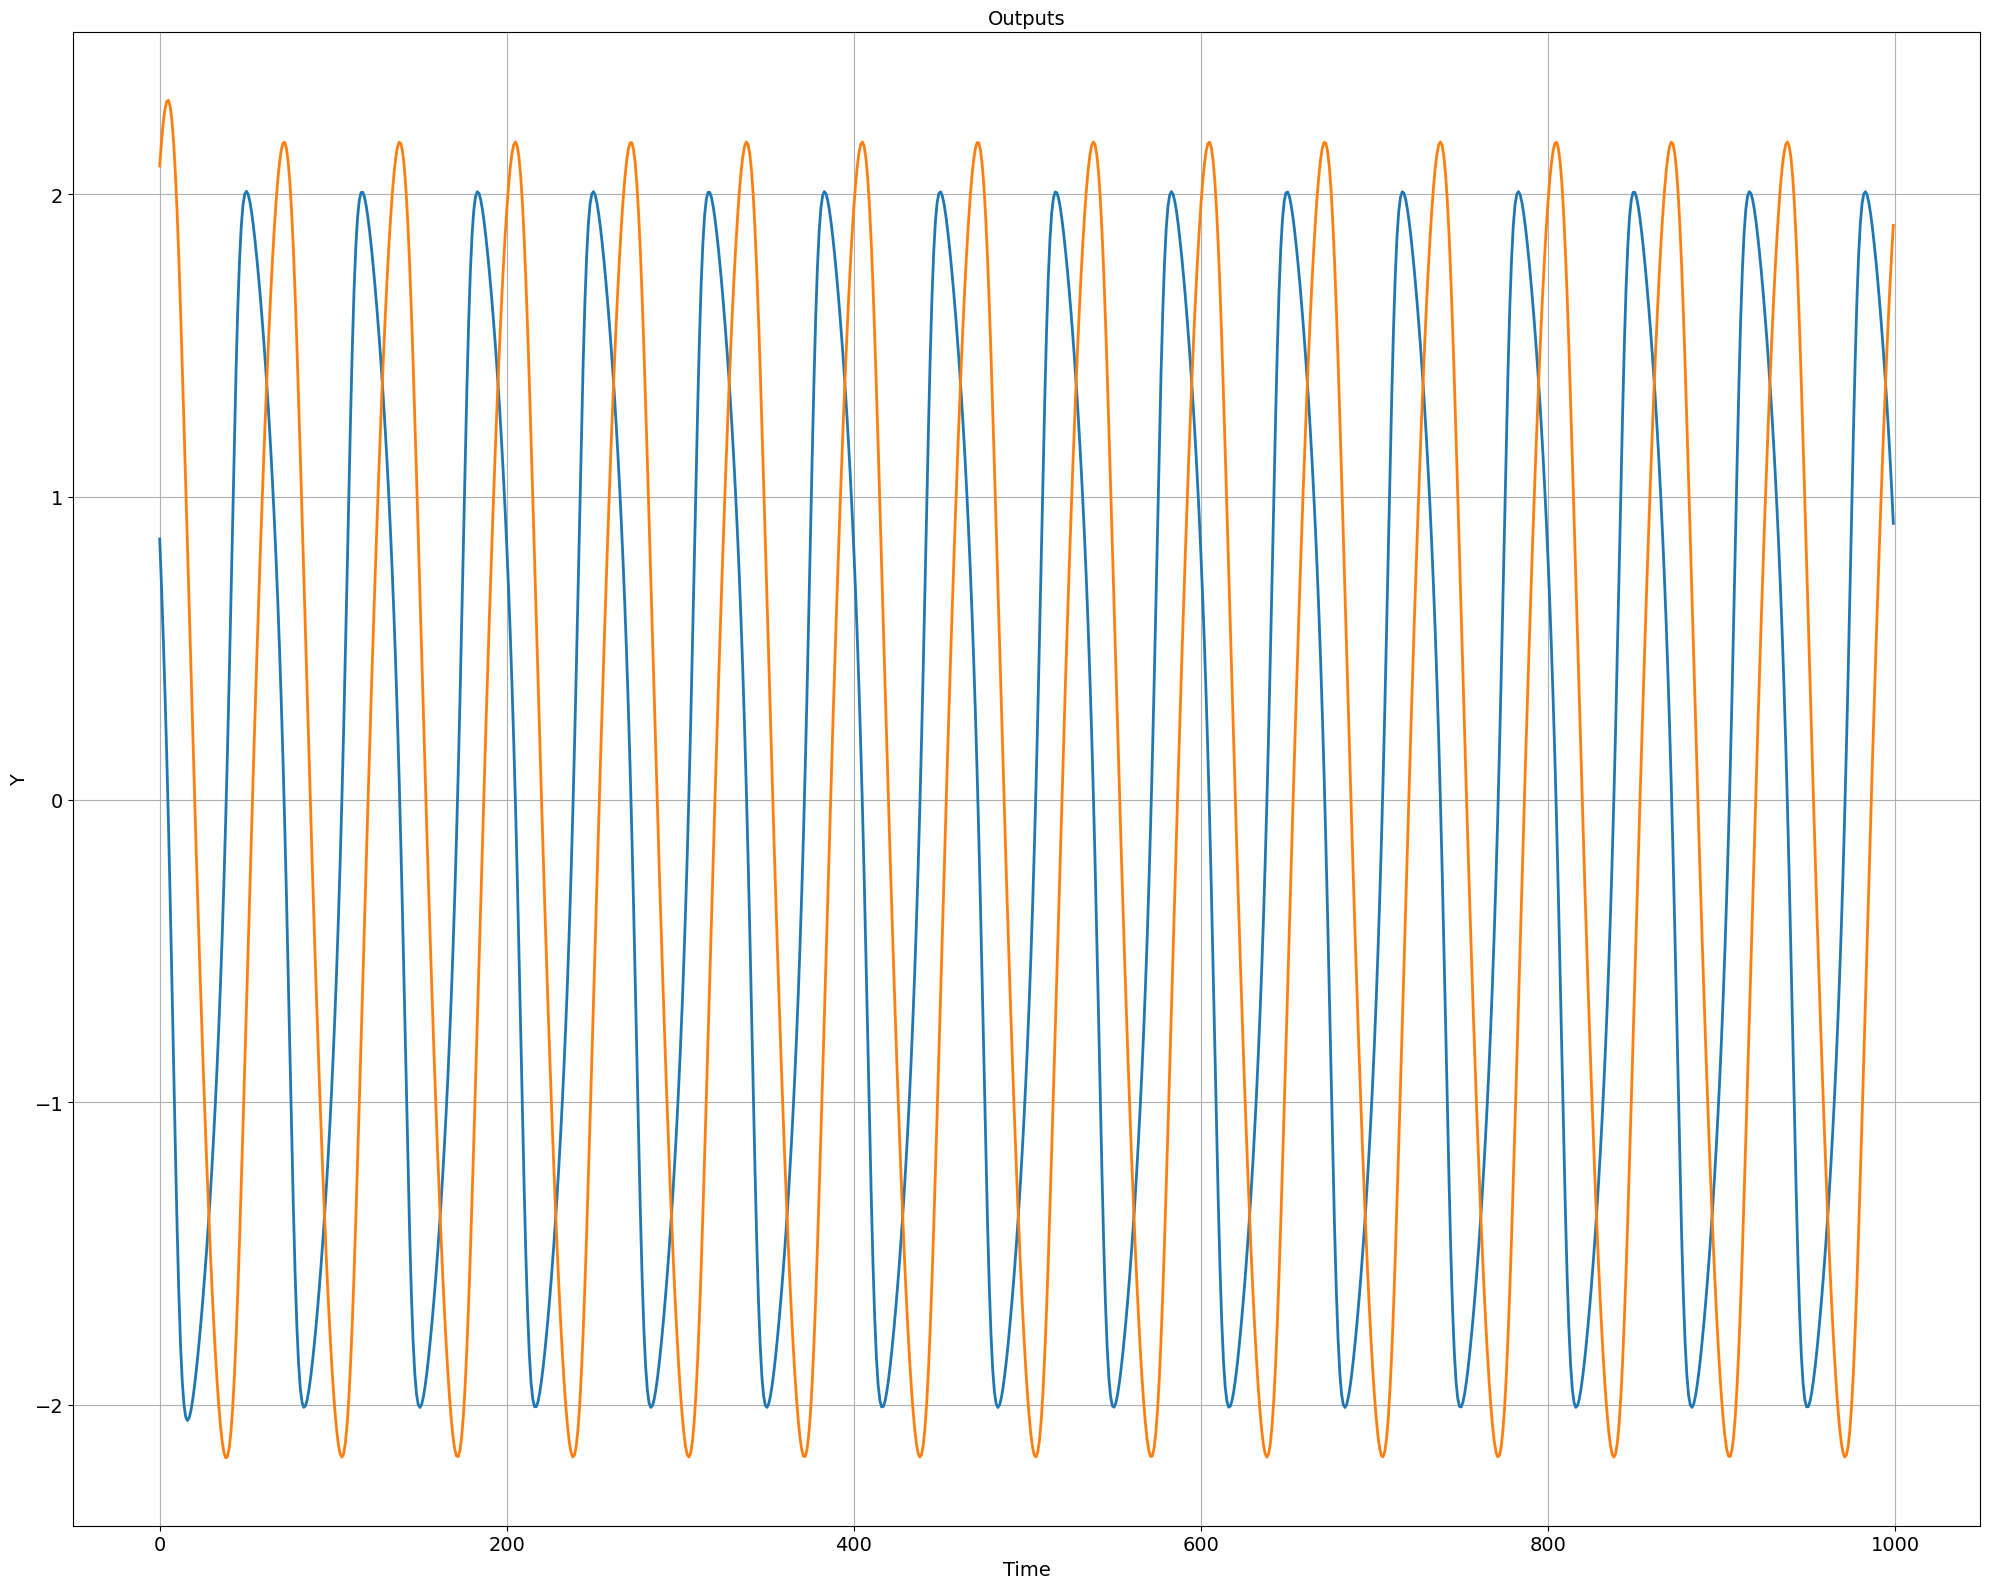

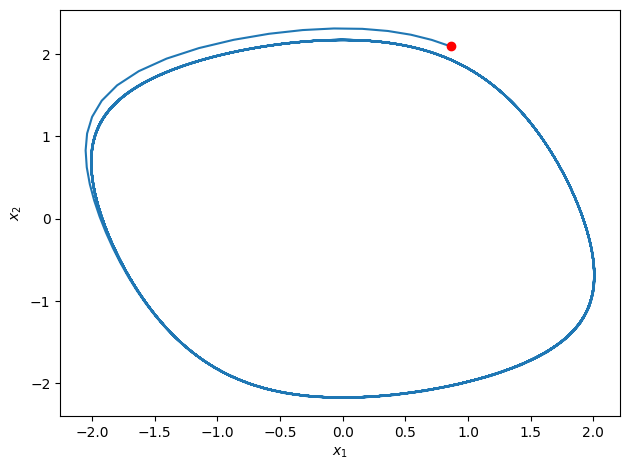

In [31]:
# %%  ground truth system
system = psl.systems['VanDerPol']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

In [7]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainY = train_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    train_data = DictDataset({'Y': trainY, 'Y0': trainY[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devY = dev_sim['Y'][:length].reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    dev_data = DictDataset({'Y': devY, 'Y0': devY[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testY = test_sim['Y'][:length].reshape(1, nsim, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    test_data = {'Y': testY, 'Y0': testY[:, 0:1, :], 'name': 'test'}

    return train_loader, dev_loader, test_data

In [8]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

In [12]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

In [13]:
# instantiate encoder neural net
encode = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder: output of which to be used to initialize the Koopman operator rollout
encode_Y0 = Node(encode, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder: output of which to be used in latent trajectory prediction loss
encode_Y = Node(encode, ['Y'], ['x_traj'], name='encoder_Y')

In [14]:
# instantiate decoder neural net
decode = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# reconstruction decoder: output of which to be used in encoder-decoder reconstruction loss
decode_y0 = Node(decode, ['x'], ['yhat0'], name='decoder_y0')
# predicted trajectory decoder: output of which to be used in output trajectory prediction loss
decode_y = Node(decode, ['x'], ['yhat'], name='decoder_y')

In [15]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [16]:
# symbolic Koopman model
Koopman = Node(K, ['x'], ['x'], name='K')

# latent Koopmann rollout over nsteps long prediction horizon
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [18]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, decode_y0, encode_Y, dynamics_model, decode_y]

In [19]:
# %% Constraints + losses:
Y = variable("Y")                      # observed outputs from the dataset
Y0 = variable('Y0')                    # observed initial conditions from the dataset
yhat = variable('yhat')                # predicted output by the encoder-decoder Koopman operator
yhat0 = variable('yhat0')              # reconstructed initial conditions by the encoder-decoder
x_traj = variable('x_traj')            # encoded trajectory in the latent space: \phi_{\theta_1}(y_{k+1}) 
x = variable('x')                      # Koopman latent space trajectory: K^k\phi_{\theta_1}(y_1)

# output trajectory prediction loss
y_loss = 10.*(yhat[:, 1:-1, :] == Y[:, 1:, :])^2
y_loss.name = "y_loss"

# one-step  output prediction loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory prediction loss
x_loss = 1.*(x[:, 1:-1, :] == x_traj[:, 1:, :])^2
x_loss.name = "x_loss"

# encoder-decoder reconstruction loss
reconstruct_loss = 1.*(Y0 == yhat0)^2
reconstruct_loss.name = "reconstruct_loss"

In [20]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruct_loss]
if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [21]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 18833


In [22]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

/home/raj/Projects/dynamical-systems-projects-/env_dyn/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 0	train_loss: 26.32223	dev_loss: 26.13415	eltime:  8.15431
epoch: 1	train_loss: 26.13414	dev_loss: 25.95629	eltime:  8.18560
epoch: 2	train_loss: 25.95629	dev_loss: 25.77995	eltime:  8.21503
epoch: 3	train_loss: 25.77995	dev_loss: 25.59616	eltime:  8.24416
epoch: 4	train_loss: 25.59616	dev_loss: 25.39720	eltime:  8.27269
epoch: 5	train_loss: 25.39720	dev_loss: 25.17435	eltime:  8.30246
epoch: 6	train_loss: 25.17435	dev_loss: 24.92078	eltime:  8.33178
epoch: 7	train_loss: 24.92078	dev_loss: 24.63028	eltime:  8.36306
epoch: 8	train_loss: 24.63028	dev_loss: 24.29714	eltime:  8.39189
epoch: 9	train_loss: 24.29714	dev_loss: 23.91706	eltime:  8.42211
epoch: 10	train_loss: 23.91705	dev_loss: 23.48718	eltime:  8.45138
epoch: 11	train_loss: 23.48718	dev_loss: 23.00627	eltime:  8.48072
epoch: 12	train_loss: 23.00627	dev_loss: 22.47607	eltime:  8.51123
epoch: 13	train_loss: 22.47607	dev_loss: 21.90202	eltime:  8.54006
epoch: 14	train_loss: 21.90202	dev_loss: 21.29256	eltime:  8.57130
epoch

<All keys matched successfully>

In [23]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [24]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T

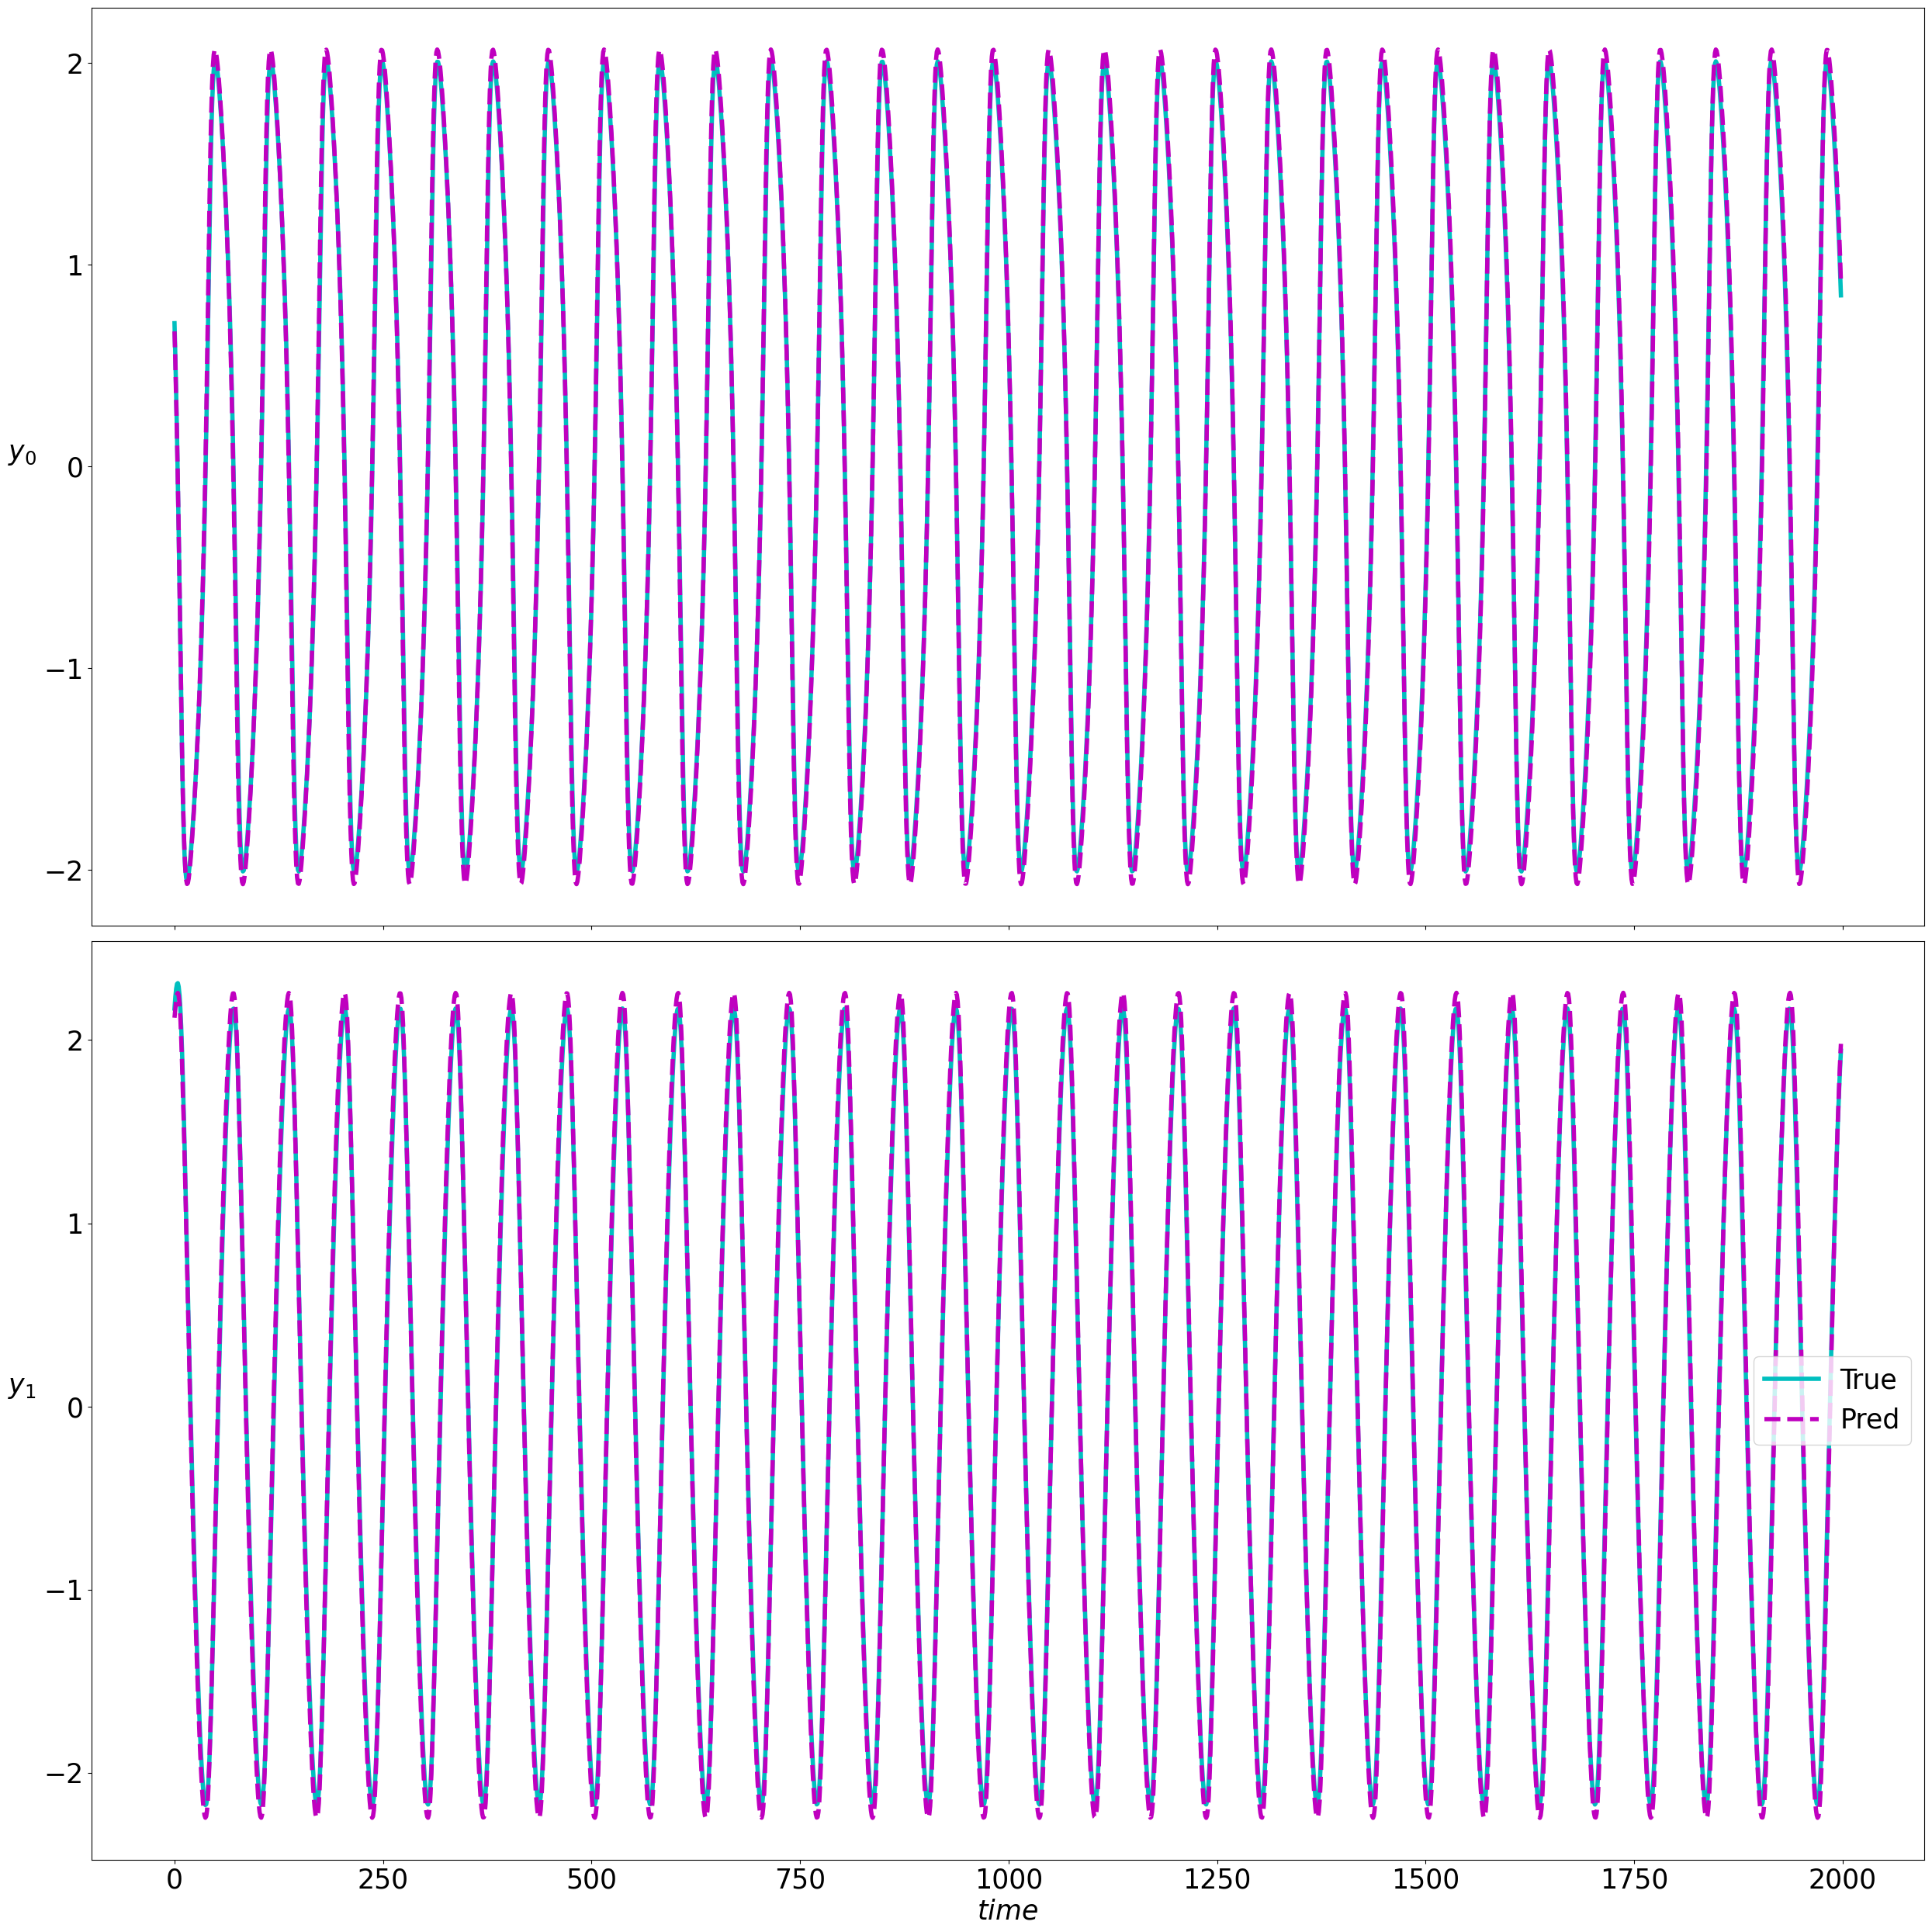

In [25]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [26]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

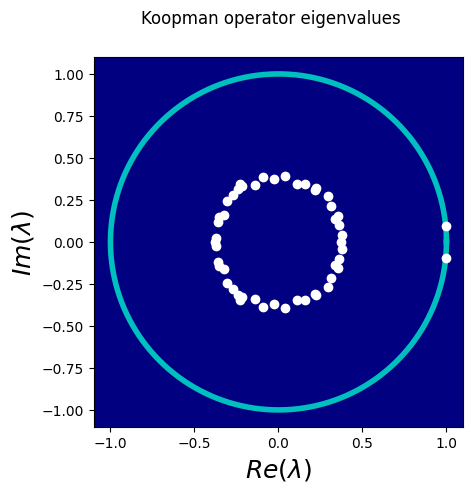

In [27]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=18)
ax1.set_ylabel("$Im(\lambda)$", fontsize=18)
fig1.suptitle('Koopman operator eigenvalues')

In [29]:
# compute Koopman eigenvectors
y1 = torch.linspace(-2.2, 2.2, 1000)
y2 = torch.linspace(-2.2, 2.2, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = encode(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]

Text(0.5, 0.98, 'first six eigenfunctions')

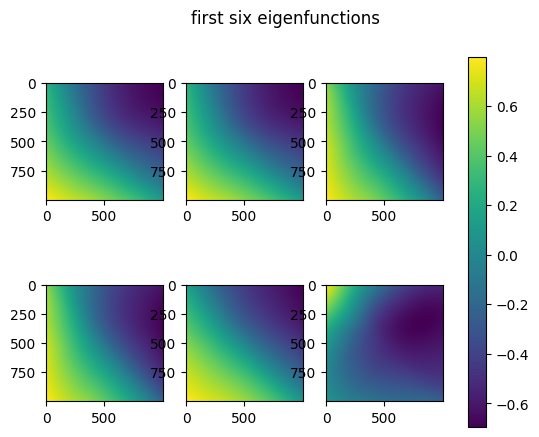

In [30]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')